# import libraries and data

In [3]:
import os
import random
import numpy as np
import pandas as pd

In [4]:
raw_data = pd.read_csv("./data/mnist_train.csv", header=None)
data = raw_data.iloc[:,1:].values
label = raw_data.iloc[:,0].values.reshape(-1,1)

In [5]:
#############################################################################
# TODO:                                                                     #
#    1) Split the entire training set to training data and validation       #
#       data. Use 80% of your data for training and 20% of your data for    #
#       validation. Note: Don't shuffle here.                               #
#############################################################################

split_ratio = 0.8
train_data = data[: int(len(data) * split_ratio)]
train_label = label[: int(len(data) * split_ratio)]
val_data = data[int(len(data) * split_ratio):]
val_label = label[int(len(data) * split_ratio):]

In [6]:
train_data.shape, train_label.shape

((48000, 784), (48000, 1))

In [7]:
#############################################################################
# TODO:                                                                     #
#    1) Shuffle data and label if shuffle=True                              #
#    In order to match expected output use random.shuffle(), not numpy      #
#    2) Generate batches of images with the required batch size             #
#    It's okay if the size of your last batch is smaller than the required  #
#    batch size                                                             #
#############################################################################

def generate_batched_data(data, label, batch_size=32, shuffle=False, seed=None):

    np.random.seed(seed)
    batched_data = []
    batched_label = []
    target_idx = list(range(0, len(data)))

    if shuffle == True:
        random.shuffle(target_idx)

    for i in range(0, data.shape[0], batch_size):
    #전체 데이터셋의 레코드수를 넘으면, 마지막 레코드-batch_size부터 있는 만큼의 데이터만 batch-ing

        if i + batch_size >= data.shape[0]:  
            batch_mask = target_idx[-batch_size:]
        else:
            batch_mask = target_idx[i:i+batch_size]  
    #     print(batch_mask)
        batched_data.append(data[batch_mask])
        batched_label.append(label[batch_mask])

    return batched_data, batched_label

In [522]:
batched_train_data, batched_train_label = generate_batched_data(data=train_data, 
                                          label=train_label, 
                                          # batch_size=32, 
                                          batch_size=1, 
                                          shuffle=False, 
                                          seed=42)

In [523]:
# 32-size의 배치로 나뉘어진 1500개의 chunk data
np.array(batched_train_data).shape, np.array(batched_train_label).shape

((48000, 1, 784), (48000, 1, 1))

# softmax regression
## Data
- X: (N of Classes=10, Input Dimension=784)
- y: (N of Classes=10)
## Forward 
W: (Input Dimension=784, N of Classes=10)
1) Initialize W
2) Z = WX+b
3) A = ReLU(Z) => activation: max(0, Z)
4) p = Softmax(A)  => ()
5) loss = CrossEntropy(p, y) => Calculate the loss


In [591]:
def ReLU(X):
    out = np.maximum(0, X)
    return out

def ReLU_dev(X):
    out = X.copy()
    out[out <= 0] = 0
    out[out > 0] = 1
    return out

def softmax(scores):
    z = scores - np.max(scores, axis=1, keepdims=True)  #to prevent overflow by exp()
    numerator = np.exp(z)
    denominator = np.sum(np.exp(z), axis=1, keepdims=True)  #sum scores for each class 
    prob = numerator / denominator
    return prob

def cross_entropy_loss(x_pred, y):
    c = 1e-7  #to prevent underflow by log(0)
    m = y.shape[0]  #batch size
    log_likelihood = x_pred * np.log(y + c)
    loss = -np.sum(log_likelihood) / m   
    return loss 

def compute_accuracy(x_pred, y):
    
    pred_idx = []
    # append the argmax(each row)
    for i in range(len(x_pred)):
        sub_x_pred = x_pred[i]
        pred_idx.append(np.argmax(sub_x_pred))
    
    acc = pred_idx == y.reshape(-1)    
    acc = np.sum(acc.astype(int)) / y.shape[0]
    # score = 0
    # pred_index = []
    # for i in range(len(x_pred)):
    #     sub_X_pred = x_pred[i]
    #     for j in range(len(sub_X_pred)):
    #         if sub_X_pred[j] == sub_X_pred.max():
    #             pred_index.append(j)
    # for n in range(len(y)):
    #     if pred_index[n] == y[n]:
    #         score += 1
    # acc = score/len(y)    
    
    return acc

In [577]:
def forward(X, y):
    m = y.shape[0]  #batch size
    n = 10 # np.max(y) + 1  #number of classes
    lr = 0.1
    
    # one-hot encoding for y 
    y_ohe = np.zeros((m, n))  #32x10 zeroes 
    y_ohe[np.arange(m), y.reshape(-1)] = 1  #정답을 인덱스로 받아 ohe에 1로 표기

    # z = np.dot(weights['W1'].T, X.T).T
    z = np.dot(X, weights['W1'])
    y_relu = ReLU(z)  # activation function 
    y_hat = softmax(y_relu)  
    dw = (1/m) * np.dot(X.T, (y_hat - y_ohe))
    gradients['W1'] = dw
    weights['W1'] -= lr * dw
   
    loss = cross_entropy_loss(y_hat, y)
    accuracy = compute_accuracy(x_pred, y)
    
    return loss, accuracy

def forward(X, y):
    batch_size = len(y)
    d_relu = ReLU_dev( np.dot(weights['W1'].T, X.T).T)
    y_hat = softmax(ReLU( np.dot(weights['W1'].T, X.T).T))
    loss = cross_entropy_loss(y_hat, y)
    accuracy = compute_accuracy(y_hat, y)
    test = np.zeros(y_hat.shape)
    for i in range(batch_size):
        test[i][y[i]] = 1
    gradient = np.dot(X.T, np.multiply(d_relu, (y_hat - test)))
    gradients['W1'] = gradient/batch_size
    return loss, accuracy

In [589]:
# params
input_size = 28*28  #the input dimension
num_classes = 10  #the number of possible labels
weights = dict()
gradients = dict()
bias = None

np.random.seed(1024)
weights['W1'] = 0.001 * np.random.randn(input_size, num_classes)  #784*10 weights matrix
gradients['W1'] = np.zeros((input_size, num_classes))
count = 0

# train function
# batch_size=32만큼 데이터를 추출해서, len=1500만큼 iteration
epochs = 1
losses = []
for epoch in range(epochs):
    for idx, (input, target) in enumerate(zip(batched_train_data, batched_train_label)): 
        # print(idx)
        loss, accuracy = forward(input, target)
    
        losses.append(loss)
    
        print(loss, accuracy)
        # lst.append(loss)
        # optimizer.update(model)
        # epoch_loss += loss
        # # hits += accuracy * input.shape[0]
        # hits += accuracy * len(input)
        # # count_samples += input.shape[0]
        # count_samples += len(input)
        

-1.6094379324341 0.0
16.11809565095832 0.0
-1.3862943861198904 0.0
-9.999999505838703e-08 0.0
-2.1972245884473303 0.0
-0.6931472305599439 0.0
-9.999999505838706e-08 0.0
-1.0986123220014423 0.0
-9.999999505838703e-08 0.0
-1.3862943861198904 0.0
-1.0986123220014423 0.0
-1.6094379324341004 1.0
-1.098612322001442 0.0
-1.791759485894722 0.0
-9.999999505838704e-08 0.0
-1.9459101633410272 0.0
-0.693147230559944 0.0
-2.0794415541798363 0.0
-1.7917594858947217 0.0
-2.1972245884473303 0.0
-1.3862943861198902 0.0
16.118095650958324 0.0
-2.1972245884473307 0.0
-9.999999505838706e-08 0.0
-9.999999505838706e-08 0.0
-0.693147230559944 0.0
-1.3862943861198902 0.0
-1.098612322001442 0.0
-0.6931472305599438 0.0
-1.9459101633410274 0.0
-1.098612322001442 0.0
-2.079441554179836 0.0
-1.7917594858947214 0.0
-2.1972245884473303 0.0
16.118095650958324 0.0
-1.6094379324341002 0.0
-1.791759485894722 1.0
16.11809565095832 0.0
-1.9459101633410274 0.0
-1.7917594858947217 0.0
-9.999999505838702e-08 0.0
-2.079441554

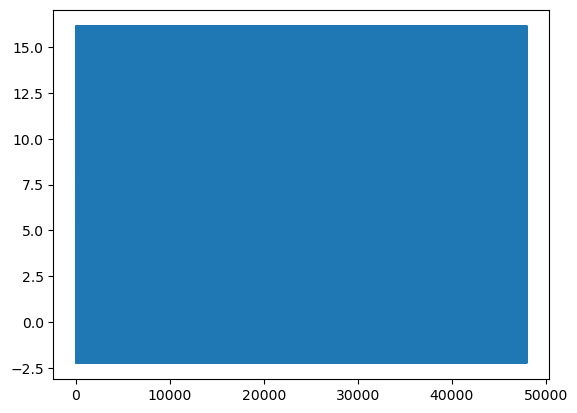

In [590]:
import matplotlib.pyplot as plt
plt.plot(losses)


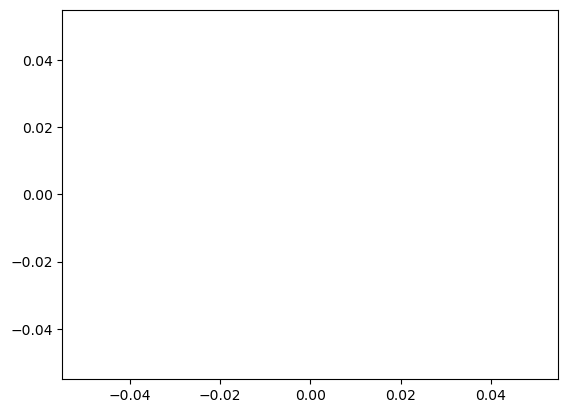

In [447]:
plt.plot(accuracy)

In [567]:
X = input.copy()
y = target.copy()

m = y.shape[0]
n = 10 # np.max(y) + 1
lr = 0.01

# one-hot encoding for y 
y_ohe = np.zeros((m, n))  #32x10 zeroes 
y_ohe[np.arange(m), y.reshape(-1)] = 1  #정답을 인덱스로 받아 ohe에 1로 표기

z = np.dot(X, weights['W1'])
y_relu = ReLU(z)  # activation function 
y_hat = softmax(y_relu)  

# dw = (1/m) * np.dot(X.T, (y_hat - y_ohe))  #dloss/dw= -2 sum(loss * )
# weights['W1'] -= lr * dw
dw = (1/m) * np.dot(X.T, (y_hat - y_ohe))  #dloss/dw= -2 sum(loss * )
gradients['W1'] = dw
weights['W1'] -= lr * dw

loss = cross_entropy_loss(y_hat, y)
accuracy = compute_accuracy(y_hat, y)

In [568]:
y_out

array([[0.02160403, 0.03009118, 0.00484908, 0.0046771 , 0.0046771 ,
        0.01728288, 0.25806393, 0.06269418, 0.49541658, 0.10064395]])

In [566]:
dw

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [552]:
y_relu.shape

(1, 10)

In [ ]:
def softmax(scores):
    z = scores - np.max(scores, axis=1, keepdims=True)  #to prevent overflow by exp()
    numerator = np.exp(z)
    denominator = np.sum(np.exp(z), axis=1, keepdims=True)  #sum scores for each class 
    prob = numerator / denominator
    return prob

In [546]:
y_out

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])

In [547]:
y

array([[2]])

In [548]:
x_pred[np.arange(len(y)), y]

array([[0.02449768]])

In [538]:
def cross_entropy_loss(x_pred, y):
    loss = -np.mean(np.log(x_pred[np.arange(len(y)), y]))
    
    # log_likelihood = x_pred * np.log(y + c)
    # loss = -np.sum(log_likelihood) / m   
    # loss = -np.mean(log_likelihood)  
    return loss 


In [541]:
sx = np.array([[0.2, 0.5, 0.3], [0.5, 0.1, 0.4], [0.3, 0.3, 0.4]])
sy = np.array([1, 2, 0])
expected_loss = 0.937803

In [542]:
cross_entropy_loss(sx,sy)

0.9378035722533454

In [475]:
ll = sx * np.log(sy+c)

In [486]:
sx[np.arange(len(sy)), sy]

array([0.5, 0.4, 0.3])

In [495]:
log_likelihood

array([-0.69314718, -0.91629073, -1.2039728 ])

In [494]:
log_likelihood = np.log(sx[np.arange(len(sy)), sy])
-np.mean(log_likelihood)

0.9378035722533454

In [491]:
sx * np.log(sy+c)

array([[ 1.99999990e-08,  3.46573615e-01, -4.83542870e+00],
       [ 4.99999975e-08,  6.93147231e-02, -6.44723826e+00],
       [ 2.99999985e-08,  2.07944169e-01, -6.44723826e+00]])

In [490]:
-np.mean(sx * np.log(sy+c))

/var/folders/pj/18_x3q214nz79c9kby44797c0000gn/T/ipykernel_28678/1182721776.py:1: RuntimeWarning: divide by zero encountered in log
  -np.mean(sx * np.log(sy))


inf

In [481]:
cross_entropy_loss(sx, sy)

5.70202420285007

In [ ]:

loss = self.model.cross_entropy_loss(sx, sy)
self.assertAlmostEqual(loss, expected_loss, places=5)

In [464]:
-np.sum(x_pred * np.log(y_ohe + c)) / m

15.540530675501593

In [ ]:
-np.mean(
    np.log(y_hat[np.arange(len(y)), y])
)

In [321]:
input.shape

(32, 784)

In [249]:
loss, accuracy

(15.540530675501593, 0.0)

In [227]:
test = np.zeros(x_pred.shape)

In [229]:
test.shape

(32, 10)

In [231]:
y[0]

array([5])

In [245]:
a.shape, errors.shape

((32, 10), (32, 10))

In [253]:
input.shape

(32, 784)

In [ ]:
    # dw = ((pred - y_batch) * x_batch).mean(0)
    # dw = dw.reshape(dw.shape[0], 1)
    # db = (pred - y_batch).mean()
    # w -= dw * learning_rate
    # b -= db * learning_rate  

In [265]:
dw.shape

(10,)

In [281]:
gradients['W1'].shape

(10, 1)

In [285]:
gradients['W1']

array([[ 4.30800095e-01],
       [-8.84083726e-02],
       [-7.59971638e-02],
       [-3.79616592e-02],
       [ 1.13668587e-03],
       [ 1.06698469e-01],
       [ 1.18520535e+00],
       [ 6.64501500e-02],
       [ 4.71177456e-01],
       [ 3.13449432e-01]])

In [275]:
dw.shape

(10, 1)

In [257]:
# errors * a

In [243]:
errors = x_pred - y_ohe
np.multiply(a, errors)

array([[ 7.80751371e-02,  1.46803195e-01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
         2.04414877e+00,  0.00000000e+00,  0.00000000e+00,
         3.33294683e-02],
       [ 1.76254180e+00, -8.64353576e-01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  3.18299922e-02,
         3.60554758e-01,  0.00000000e+00,  3.94987966e-02,
         1.13812245e+00],
       [ 3.47819685e-03,  5.33651570e-03,  0.00000000e+00,
        -1.23119411e+00,  5.24227179e-04,  1.51103172e-03,
         5.23334549e+00,  2.08038821e-01,  4.22552518e-01,
         1.08774972e-03],
       [ 6.25021327e-01,  2.00837620e-02, -1.24896358e+00,
         0.00000000e+00,  1.30360482e-03,  9.18479933e-01,
         3.68046546e-01,  1.20576392e+00,  1.70131693e-01,
         0.00000000e+00],
       [ 0.00000000e+00,  6.38449127e-03,  4.39151545e-01,
         0.00000000e+00,  0.00000000e+00, -1.56053096e+00,
         8.22386668e-02,  0.00000000e+00,  2.03261647e-01,
         2.

In [ ]:
dw=(np.dot((y_hat-y),x)*2)/len(y)
b_1=b_0-learning_rate*db
theta_1=theta_o-learning_rate*dw

In [234]:

# gradient = np.dot(x.T, np.multiply(a, (x_pred - y_ohe)))
# gradients['W1'] = gradient/batch_size

In [170]:
p.shape, y_ohe.shape

((32, 10), (32, 9))

In [179]:
loss

15.540530675501593

In [185]:
x_pred.ndim

2

In [183]:
len(x_pred)

32

In [189]:
sub_x_pred.max()

0.4954165758177344

In [190]:
sub_x_pred

array([0.02160403, 0.03009118, 0.00484908, 0.0046771 , 0.0046771 ,
       0.01728288, 0.25806393, 0.06269418, 0.49541658, 0.10064395])

In [198]:
sub_x_pred

array([0.02160403, 0.03009118, 0.00484908, 0.0046771 , 0.0046771 ,
       0.01728288, 0.25806393, 0.06269418, 0.49541658, 0.10064395])

In [194]:
np.argmax(sub_x_pred)

8

In [197]:
print(np.argmax(sub_x_pred))

8


In [199]:
np.argmax(x_pred[i])

8

0.0

In [222]:
y.shape[0]

32

In [214]:
acc

0.0

In [210]:
y.reshape(-1)

array([5, 1, 3, 2, 5, 2, 9, 3, 0, 1, 7, 3, 6, 4, 1, 5, 2, 1, 1, 9, 7, 8,
       2, 1, 3, 1, 1, 5, 4, 0, 1, 2])

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

In [206]:
pred_idx == y

array([[False, False, False, ...,  True, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False,  True, False, ..., False,  True, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [203]:
pred_idx == pred_idx_v2

True

In [150]:

for i in range(len(x_pred)):
    sub_X_pred = x_pred[i]
    for j in range(len(sub_X_pred)):
        if sub_X_pred[j] == sub_X_pred.max():
            pred_index.append(j)
for n in range(len(y)):
    if pred_index[n] == y[n]:
        score += 1
acc = score/len(y)

NameError: name 'c' is not defined

In [155]:
y_ohe

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 

In [166]:
c = 1e-7  #to prevent underflow by log(0)
batch_size = y_ohe.shape[0]
log_likelihood = p * np.log(y_ohe + c)
loss = -np.sum(log_likelihood) / batch_size

In [165]:
-np.sum(log_likelihood)

497.29698161605097

In [164]:
-log_likelihood.sum(axis=1) / batch_size

array([0.49135124, 0.49351344, 0.50122283, 0.4922814 , 0.47343228,
       0.5018221 , 0.47173445, 0.50216855, 0.47262964, 0.49146187,
       0.4683611 , 0.49800108, 0.48307511, 0.47999771, 0.49439502,
       0.46056232, 0.46716533, 0.49696679, 0.46923536, 0.477695  ,
       0.48415654, 0.4846548 , 0.49404684, 0.48786487, 0.50335234,
       0.49625107, 0.46820959, 0.4543186 , 0.49076969, 0.50277211,
       0.48581357, 0.50124806])

In [157]:
loss

15.540530675501593

In [146]:
batch_size

32

In [119]:
def cross_entropy_loss(y, t):
    c = 1e-7

    batch_size = y.shape[0]
    return -np.sum(t * np.log(y + c)) / batch_size

(32, 10)

In [108]:
# prob.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [41]:
Z.shape, A.shape

((32, 10), (32, 10))

In [45]:
Z[0], A[0]

(array([ 1.08110739,  1.4316717 , -4.69101517, -1.28011584, -6.50854083,
        -1.54936054,  3.2465618 , -0.04215777, -2.12437043,  0.68548793]),
 array([1.08110739, 1.4316717 , 0.        , 0.        , 0.        ,
        0.        , 3.2465618 , 0.        , 0.        , 0.68548793]))

array([1.08110739, 1.4316717 , 0.        , 0.        , 0.        ,
       0.        , 3.2465618 , 0.        , 0.        , 0.68548793])

In [ ]:
# from ._base_network import _baseNetwork


class SoftmaxRegression(_baseNetwork):
    def __init__(self, input_size=28 * 28, num_classes=10):
        """
        A single layer softmax regression. The network is composed by:
        a linear layer without bias => (activation) => Softmax
        :param input_size: the input dimension
        :param num_classes: the number of classes in total
        """
        super().__init__(input_size, num_classes)
        self._weight_init()

    def _weight_init(self):
        '''
        initialize weights of the single layer regression network. No bias term included.
        :return: None; self.weights is filled based on method
        - W1: The weight matrix of the linear layer of shape (num_features, hidden_size)
        '''
        np.random.seed(1024)
        self.weights['W1'] = 0.001 * np.random.randn(self.input_size, self.num_classes)
        self.gradients['W1'] = np.zeros((self.input_size, self.num_classes))
        self.count = 0

    def forward(self, X, y, mode='train'):
        """
        Compute loss and gradients using softmax with vectorization.

        :param X: a batch of image (N, 28x28)
        :param y: labels of images in the batch (N,)
        :return:
            loss: the loss associated with the batch
            accuracy: the accuracy of the batch
        """
        loss = None
        gradient = None
        accuracy = None
        #############################################################################
        # TODO:                                                                     #
        #    1) Implement the forward process and compute the Cross-Entropy loss    #
        #    2) Compute the gradient of the loss with respect to the weights        #
        # Hint:                                                                     #
        #   Store your intermediate outputs before ReLU for backwards               #
        #############################################################################


        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################
        if mode != 'train':
            return loss, accuracy

        #############################################################################
        # TODO:                                                                     #
        #    1) Implement the backward process:                                     #
        #        1) Compute gradients of each weight by chain rule                  #
        #        2) Store the gradients in self.gradients                           #
        #############################################################################

        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################
        return loss, accuracy


In [ ]:
epoch_loss = 0.0
hits = 0
count_samples = 0.0

for idx, (input, target) in enumerate(zip(batched_train_data, batched_train_label)):

    start_time = time.time()
    loss, accuracy = model.forward(input, target)
    # print(type(input), loss)

    optimizer.update(model)
    epoch_loss += loss
    hits += accuracy * input.shape[0]
    # hits += accuracy * len(input)
    count_samples += input.shape[0]
    # count_samples += len(input)

    forward_time = time.time() - start_time
    if idx % 10 == 0 and debug:
        print(('Epoch: [{0}][{1}/{2}]\t'
               'Batch Time {batch_time:.3f} \t'
               'Batch Loss {loss:.4f}\t'
               'Train Accuracy ' + "{accuracy:.4f}" '\t').format(
            epoch, idx, len(batched_train_data), batch_time=forward_time,
            loss=loss, accuracy=accuracy))
epoch_loss /= len(batched_train_data)
epoch_acc = hits / count_samples

In [ ]:
    def forward(self, x, train_flag=True):
        if x.shape[0] > 1024:  # if too much input size: memory :(
            temp_x = np.zeros((x.shape[0], 10))
            for i in range(0, x.shape[0], x.shape[0] // 10):
                temp_x[i:i + x.shape[0] // 10] = self.forward(x[i:i + x.shape[0] // 10], False)
            x = temp_x
        else:
            for i in range(len(self.keys) - 1):
                key = self.keys[i]
                if isinstance(self.layers[key], Dropout):
                    x = self.layers[key].forward(x, train_flag)
                else:
                    x = self.layers[key].forward(x)
                if key in self.weight_decay_lambda:
                    self.l2[key] = np.sum(np.square(self.params[key])) * self.weight_decay_lambda[key]
        return x
